In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats, spatial
import pickle
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
tfidf_path = '../../data/tfidf_merged_chs_202001/'

In [3]:
lda_path = '../../data/lda_merged_chs_202001/'

In [4]:
fandom_list = [i for i in os.listdir(lda_path) if 'tsv' in i]

In [5]:
fandom_list

['doctor_who_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'hetalia_axis_powers_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'buffy_the_vampire_slayer_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'attack_on_titan_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'shakespare_william_works_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'the_walking_dead_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'dragon_age_all_media_types_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'arthurian_mythology_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'sherlock_holmes_&_related_fandoms_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'harry_potter_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'one_direction_temporal_lda_jsd_toprev_with_dist_merged_chs_sampled.tsv',
 'tolkien_j_r_r_works_&_related_fandoms_temporal_lda_

In [6]:
def var_bootstrap_resample(li):
    if len(li) > 0:
        var_original = np.var(li)
        var_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            var_s.append(np.var(sample))
        tail = sorted(var_s)[5]
        head = sorted(var_s)[95]
        return (var_original, tail, head)

In [7]:
def ave_bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        ave_s = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            ave_s.append(np.average(sample))
        tail = sorted(ave_s)[5]
        head = sorted(ave_s)[95]
        return (ave_original, tail, head)

In [8]:
def create_normed_dfs(df, field):

#     turn into z scores
    df[field] = np.log(df[field]+1)
    df = df.replace([np.inf, -np.inf], np.nan)
    df[field].dropna()
    df[field] = (df[field] - df[field].mean())/df[field].std(ddof=0)

    return df

In [61]:
def create_dict(df, nov_field, suc_field, metric):
    
    # Make bins
    df[nov_field] = df[nov_field].astype(float)
    term_n = sorted(df[nov_field].tolist())
    term_n = np.quantile(term_n, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    term_n = np.insert(term_n, 0, 0)
    term_n = np.concatenate([term_n, [1]])
    dic = {}
    for i in range(len(term_n)-1):
        df_s = df[(df[nov_field] >= term_n[i]) & (df[nov_field] < term_n[i+1])]
        li = df_s[suc_field].tolist()
        if len(li) > 0:
            if metric == 'ave':
                dic[term_n[i]] = ave_bootstrap_resample(li)
            elif metric == 'var':
                dic[term_n[i]] = var_bootstrap_resample(li)
    return dic

In [10]:
def generate_res(path, nov_field, suc_field, metric):
    df_all = []
    fandom_list = [i for i in os.listdir(path) if 'tsv' in i]
    for i,fandom in enumerate(fandom_list):
        df = pd.read_csv(os.path.join(path,fandom), sep = '\t')
        df = create_normed_dfs(df, suc_field)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[[nov_field, suc_field]].dropna()
        df_all.append(df)

    df = pd.concat(df_all)
    df = df.sort_values(by = nov_field)
    df = df.sort_values(by = suc_field)
    dic = create_dict(df, nov_field, suc_field, metric)

    return dic
    

In [62]:
lda_kudos_dict_var = generate_res(lda_path, 'JSD','Kudos', 'var')
# lda_hits_dict_var = generate_res(lda_path, 'JSD','Hits', 'var')
# lda_comments_dict_var = generate_res(lda_path, 'JSD','Comments', 'var')
# lda_bookmarks_dict_var = generate_res(lda_path, 'JSD','Bookmarks', 'var')

In [12]:
# pickle.dump(lda_kudos_dict_var, open('lda_kudos_dict_var.p', 'wb'))
# pickle.dump(lda_hits_dict_var, open('lda_hits_dict_var.p', 'wb'))
# pickle.dump(lda_comments_dict_var, open('lda_comments_dict_var.p', 'wb'))
# pickle.dump(lda_bookmarks_dict_var, open('lda_bookmarks_dict_var.p', 'wb'))

In [13]:
tfidf_kudos_dict_var = generate_res(tfidf_path, 'Cos', 'Kudos', 'var')
tfidf_hits_dict_var = generate_res(tfidf_path, 'Cos', 'Hits', 'var')
tfidf_comments_dict_var = generate_res(tfidf_path, 'Cos', 'Comments', 'var')
tfidf_bookmarks_dict_var = generate_res(tfidf_path, 'Cos', 'Bookmarks', 'var')

In [14]:
# pickle.dump(tfidf_kudos_dict_var, open('tfidf_kudos_dict_var.p', 'wb'))
# pickle.dump(tfidf_hits_dict_var, open('tfidf_hits_dict_var.p', 'wb'))
# pickle.dump(tfidf_comments_dict_var, open('tfidf_comments_dict_var.p', 'wb'))
# pickle.dump(tfidf_bookmarks_dict_var, open('tfidf_bookmarks_dict_var.p', 'wb'))

In [15]:
lda_kudos_dict_ave = generate_res(lda_path, 'JSD','Kudos', 'ave')
lda_hits_dict_ave = generate_res(lda_path, 'JSD','Hits', 'ave')
lda_comments_dict_ave = generate_res(lda_path, 'JSD','Comments', 'ave')
lda_bookmarks_dict_ave = generate_res(lda_path, 'JSD','Bookmarks', 'ave')

In [16]:
# pickle.dump(lda_kudos_dict_ave, open('lda_kudos_dict_ave.p', 'wb'))
# pickle.dump(lda_hits_dict_ave, open('lda_hits_dict_ave.p', 'wb'))
# pickle.dump(lda_comments_dict_ave, open('lda_comments_dict_ave.p', 'wb'))
# pickle.dump(lda_bookmarks_dict_ave, open('lda_bookmarks_dict_ave.p', 'wb'))

In [17]:
tfidf_kudos_dict_ave = generate_res(tfidf_path, 'Cos', 'Kudos', 'ave')
tfidf_hits_dict_ave = generate_res(tfidf_path, 'Cos', 'Hits', 'ave')
tfidf_comments_dict_ave = generate_res(tfidf_path, 'Cos', 'Comments', 'ave')
tfidf_bookmarks_dict_ave = generate_res(tfidf_path, 'Cos', 'Bookmarks', 'ave')

In [18]:
# pickle.dump(tfidf_kudos_dict_ave, open('tfidf_kudos_dict_ave.p', 'wb'))
# pickle.dump(tfidf_hits_dict_ave, open('tfidf_hits_dict_ave.p', 'wb'))
# pickle.dump(tfidf_comments_dict_ave, open('tfidf_comments_dict_ave.p', 'wb'))
# pickle.dump(tfidf_bookmarks_dict_ave, open('tfidf_bookmarks_dict_ave.p', 'wb'))

In [100]:
# lda_kudos_dict_var = pickle.load(open('lda_kudos_dict_var.p', 'rb'))
# lda_hits_dict_var = pickle.load(open('lda_hits_dict_var.p', 'rb'))
# lda_comments_dict_var = pickle.load(open('lda_comments_dict_var.p', 'rb'))
# lda_bookmarks_dict_var = pickle.load(open('lda_bookmarks_dict_var.p', 'rb'))

In [101]:
# tfidf_kudos_dict_ave = pickle.load(open('tfidf_kudos_dict_ave.p', 'rb'))
# tfidf_hits_dict_ave = pickle.load(open('tfidf_hits_dict_ave.p', 'rb'))
# tfidf_comments_dict_ave = pickle.load(open('tfidf_comments_dict_ave.p', 'rb'))
# tfidf_bookmarks_dict_ave = pickle.load(open('tfidf_bookmarks_dict_ave.p', 'rb'))

In [102]:
# lda_kudos_dict_ave = pickle.load(open('lda_kudos_dict_ave.p', 'rb'))
# lda_hits_dict_ave = pickle.load(open('lda_hits_dict_ave.p', 'rb'))
# lda_comments_dict_ave = pickle.load(open('lda_comments_dict_ave.p', 'rb'))
# lda_bookmarks_dict_ave = pickle.load(open('lda_bookmarks_dict_ave.p', 'rb'))

In [103]:
# tfidf_kudos_dict_var = pickle.load(open('tfidf_kudos_dict_var.p', 'rb'))
# tfidf_hits_dict_var = pickle.load(open('tfidf_hits_dict_var.p', 'rb'))
# tfidf_comments_dict_var = pickle.load(open('tfidf_comments_dict_var.p', 'rb'))
# tfidf_bookmarks_dict_var = pickle.load(open('tfidf_bookmarks_dict_var.p', 'rb'))

In [63]:
def create_xs(keys):
    xs = []
    for i in range(len(keys)-1):
        xs.append(keys[i] + (keys[i+1] - keys[i])/2)
    return xs

In [64]:
def extract_plot_vals(dic):
    keys = sorted(dic.keys())
    keys.append(1)
    x = create_xs(keys)
    y = [dic[j][0] for j in keys[:-1]]
    lower_error = [dic[j][0] - dic[j][1] for j in keys[:-1]]
    upper_error = [dic[j][2] - dic[j][0] for j in keys[:-1]]
    asymmetric_error = [lower_error, upper_error]
    return x,y,asymmetric_error

In [65]:
lda_kudos_dict_ave.keys()

dict_keys([0.0, 0.12217557009935263, 0.16351842846747786, 0.2005826854017414, 0.23685385691255764, 0.2738223537824069, 0.3135207158782123, 0.3577452206880479, 0.41176382939863754, 0.48534291975311833])

In [66]:
x,y,e = extract_plot_vals(lda_kudos_dict_ave)
print(x)

[0.06108778504967632, 0.14284699928341524, 0.18205055693460964, 0.21871827115714954, 0.25533810534748225, 0.2936715348303096, 0.3356329682831301, 0.38475452504334273, 0.44855337457587796, 0.7426714598765591]


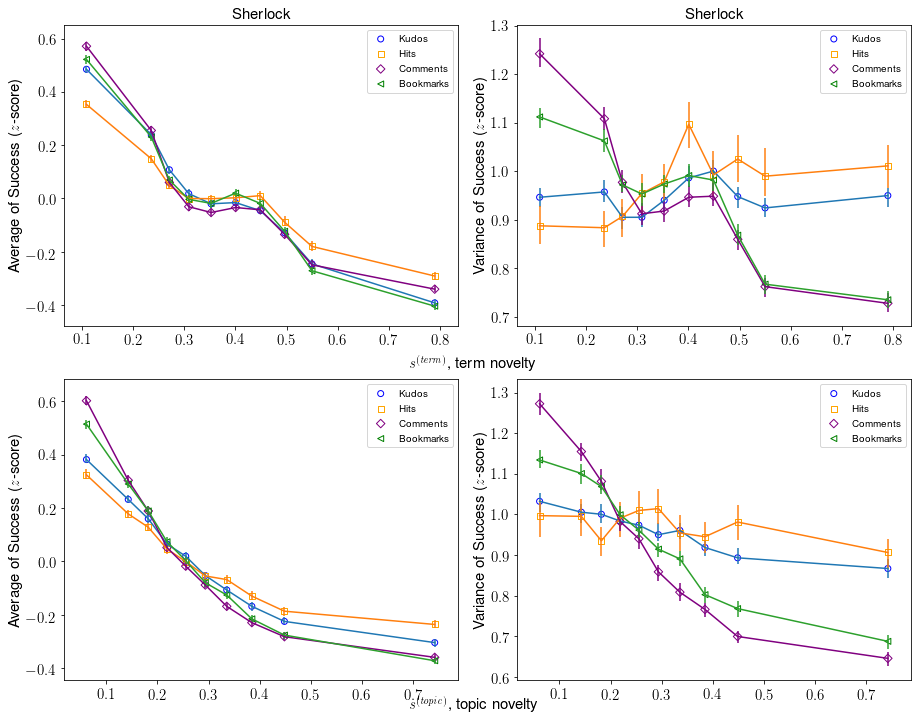

In [67]:
fig = plt.figure(figsize=(13,10))
fig.subplots_adjust(bottom = 0.4)


plt.subplot(2, 2, 1)

x, y, err = extract_plot_vals(tfidf_kudos_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='blue')

x, y, err = extract_plot_vals(tfidf_hits_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(tfidf_comments_dict_ave)
plt.errorbar(x, y, yerr=err, c='purple')
plt.scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(tfidf_bookmarks_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')

plt.legend()
# plt.xlabel('$\it{s}^{(term)}$, term novelty',fontsize=15)
plt.ylabel('Average of Success ($\it{z}$-score)',fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Sherlock', fontsize=15)

# fig.text(0.03, 0.45, 'Variance in Success ($\it{z}$-score)', ha='center', va='center', rotation='vertical', fontsize=15)

plt.subplot(2, 2, 2)

x, y, err = extract_plot_vals(tfidf_kudos_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='blue')

x, y, err = extract_plot_vals(tfidf_hits_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(tfidf_comments_dict_var)
plt.errorbar(x, y, yerr=err, c='purple')
plt.scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(tfidf_bookmarks_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
plt.ylabel('Variance of Success ($\it{z}$-score)',fontsize=15)
plt.legend()
plt.tick_params(labelsize=15)
plt.title('Sherlock', fontsize=15)


plt.subplot(2, 2, 3)

x, y, err = extract_plot_vals(lda_kudos_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='blue')

x, y, err = extract_plot_vals(lda_hits_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(lda_comments_dict_ave)
plt.errorbar(x, y, yerr=err, c='purple')
plt.scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(lda_bookmarks_dict_ave)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')

plt.legend()
# plt.xlabel('$\it{s}^{(topic)}$, topic novelty',fontsize=15)
plt.ylabel('Average of Success ($\it{z}$-score)',fontsize=15)
plt.tick_params(labelsize=15)
# plt.subplots_adjust(hspace = 0.5)

# fig.text(0.03, 0.45, 'Variance in Success ($\it{z}$-score)', ha='center', va='center', rotation='vertical', fontsize=15)

plt.subplot(2, 2, 4)

x, y, err = extract_plot_vals(lda_kudos_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, label = 'Kudos',facecolor='none',edgecolor='blue')

x, y, err = extract_plot_vals(lda_hits_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker='s', label = 'Hits',facecolor='none',edgecolor='orange')

x, y, err = extract_plot_vals(lda_comments_dict_var)
plt.errorbar(x, y, yerr=err, c='purple')
plt.scatter(x, y, marker='D', label = 'Comments',facecolor='none',edgecolor='purple')

x, y, err = extract_plot_vals(lda_bookmarks_dict_var)
plt.errorbar(x, y, yerr=err)
plt.scatter(x, y, marker = '<', label = 'Bookmarks',facecolor='none',edgecolor='green')
plt.tick_params(labelsize=15)


plt.legend()
# plt.xlabel('$\it{s}^{(topic)}$, topic novelty', fontsize = 15)
plt.ylabel('Variance of Success ($\it{z}$-score)',fontsize=15)

fig.text(0.45, 0.48, '$\it{s}^{(term)}$, term novelty',fontsize=15)
fig.text(0.45, 0.006, '$\it{s}^{(topic)}$, topic novelty',fontsize=15)


plt.tight_layout()
plt.savefig('scatter_var_ave.pdf', type='pdf')


### More plots

In [41]:
df_all = []
fandom_list = [i for i in os.listdir(tfidf_path) if 'tsv' in i]
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(tfidf_path,fandom), sep = '\t')
    df = create_normed_dfs(df, 'Kudos')
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df[['Cos', 'Kudos']].dropna()
    df_all.append(df)

df = pd.concat(df_all)
df = df.sort_values(by = 'Cos')
df = df.sort_values(by = 'Kudos')

In [33]:
len(df)

105099

In [42]:
term_n = sorted(df['Cos'].tolist())
term_n = np.quantile(term_n, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
term_n = np.insert(term_n, 0, 0)
term_n = np.concatenate([term_n, [1]])

In [43]:
term_n

array([0.        , 0.21775219, 0.25335269, 0.28852427, 0.32909676,
       0.37594216, 0.42506434, 0.47262477, 0.51997441, 0.57952257,
       1.        ])

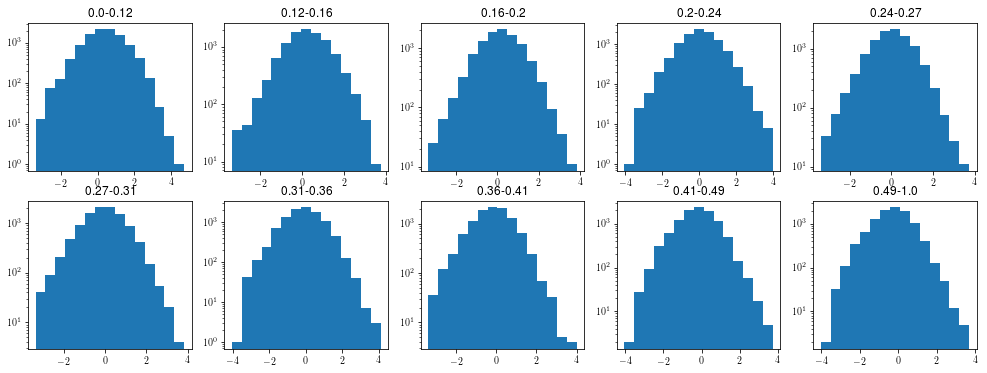

In [36]:
fig = plt.figure(figsize=(17, 6))
for i in range(len(term_n)-1):
    df_s = df[(df['JSD'] >= term_n[i]) & (df['JSD'] < term_n[i+1])]
    fig.add_subplot(2,5,i+1)
    plt.hist(df_s['Kudos'], bins=15)
    plt.yscale('log')
    plt.title(str(round(term_n[i], 2)) + '-' + str(round(term_n[i+1], 2)))

(array([6.7020e+03, 2.5296e+04, 2.0924e+04, 1.8893e+04, 1.8430e+04,
        1.0579e+04, 3.3640e+03, 7.4800e+02, 1.4400e+02, 1.9000e+01]),
 array([0.11513388, 0.20261149, 0.2900891 , 0.37756671, 0.46504432,
        0.55252193, 0.63999954, 0.72747715, 0.81495476, 0.90243237,
        0.98990998]),
 <a list of 10 Patch objects>)

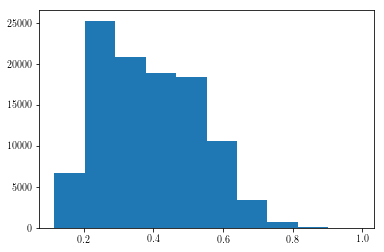

In [44]:
plt.hist(df.Cos)